In [ ]:
# Install required packages
! pip install transformers==4.0.0 sentencepiece==0.1.91

     |████████████████████████████████| 1.4MB 12.9MB/s 
     |████████████████████████████████| 1.1MB 50.7MB/s 
     |████████████████████████████████| 890kB 54.1MB/s 
     |████████████████████████████████| 2.9MB 46.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=3037cba028bd225f9e8fd050bfba5d6bb9ec8382c546f405acb2cc21158d158e
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [ ]:
import random
import copy
import json
import queue
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as sched
import torch.utils.data as data

from pathlib import Path
from collections import defaultdict
from sklearn.datasets import fetch_20newsgroups
from torch.utils.tensorboard import SummaryWriter
from transformers import AlbertTokenizer, AlbertModel
from tqdm.notebook import tqdm

In [ ]:
"""Specify GPU"""
gpu_device = torch.cuda.get_device_name()
if gpu_device != 'Tesla P100-PCIE-16GB':
    raise ValueError("GPU device is not Tesla P100.")

In [ ]:
"""Define utility functions and classes"""
def get_save_dir(base_dir, name, id_max=100):
    """Get a unique save directory by appending the smallest positive integer
    `id < id_max` that is not already taken (i.e., no dir exists with that id).
    Args:
        base_dir (str): Base directory in which to make save directories.
        name (str): Name to identify this training run. Need not be unique.
        id_max (int): Maximum ID number before raising an exception.
    Returns:
        save_dir (str): Path to a new directory with a unique name.
    """
    for uid in range(1, id_max):
        name_uid = f'{name}-{uid:02d}'
        save_dir = Path(base_dir, name_uid)
        if not save_dir.exists():
            save_dir.mkdir(parents=True)
            return save_dir, name_uid
    raise RuntimeError('Too many save directories crewated with the same name. \
                        Delete old save directories or use another name.')

def load_model(model, checkpoint_path, device, return_step=True):
    """Load model parameters from disk.
    Args:
        model (torch.nn.Module): Load parameters into this model.
        checkpoint_path (str): Path to checkpoint to load.
        device (torch.device): Indicate the location where all tensors should be loaded.
        return_step (bool): Also return the step at which checkpoint was saved.
    Returns:
        model (torch.nn.DataParallel): Model loaded from checkpoint.
        step (int): Step at which checkpoint was saved. Only if `return_step`.
    """
    ckpt_dict = torch.load(checkpoint_path, map_location=device)
    
    # Build model, load parameters
    model.load_state_dict(ckpt_dict['model_state'])

    if return_step:
        step = ckpt_dict['step']
        return model, step

    return model

class CheckpointSaver:
    """Class to save and load model checkpoints.
    Save the best checkpoints as measured by a metric value passed into the
    `save` method.
    Args:
        save_dir (str): Directory to save checkpoints.
        maximize_metric (bool): If true, best checkpoint is that which maximizes
            the metric value passed in via `save`. Otherwise, best checkpoint
            minimizes the metric.
    """
    def __init__(self, save_dir, maximize_metric=False):
        self.save_dir = save_dir
        self.maximize_metric = maximize_metric
        self.best_val = None
        
    def is_best(self, metric_val):
        """Check whether `metric_val` is the best seen so far.
        Args:
            metric_val (float): Metric value to compare to prior checkpoints.
        """
        if metric_val is None:
            # No metric reported
            return False

        if self.best_val is None:
            # No checkpoint saved yet
            return True
        
        return ((self.maximize_metric and self.best_val < metric_val)
                or (not self.maximize_metric and self.best_val > metric_val))

    def save(self, step, model, metric_val, device):
        """Save model parameters to disk.
        Args:
            step (int): Total number of examples seen during training so far.
            model (torch.nn.DataParallel): Model to save.
            metric_val (float): Determines whether checkpoint is best so far.
            device (torch.device): Device where model resides.
        """
        ckpt_dict = {
            'model_name': model.__class__.__name__,
            'model_state': model.cpu().state_dict(),
            'step': step
        }
        model.to(device)

        # Save the best model
        self.best_val = metric_val
        best_path = self.save_dir.joinpath('best.pth.tar')
        torch.save(ckpt_dict, best_path)
 
class AverageMeter:
    """Keep track of average values over time."""
    def __init__(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def reset(self):
        """Reset meter."""
        self.__init__()
    
    def update(self, val, num_samples=1):
        """Update meter with new value `val`, the average of `num` samples.
        Args:
            val (float): Average value to update the meter with.
            num_samples (int): Number of samples that were averaged to
                produce `val`.
        """
        self.count += num_samples
        self.sum += val * num_samples
        self.avg = self.sum / self.count

In [ ]:
"""Define arguments and set up data and tokenizer"""
# Define arguments
def get_args():
    def args():
        pass
    # Arguments for setup
    args.name = '20newsgroups'
    args.base_dir = 'drive/MyDrive/colab'
    args.threshold = 4096
    args.chunk = 150
    args.overlap = 50

    # Arguments for model
    args.pretrained_model = 'albert-base-v2'
    args.num_labels = 20
    args.hidden_size = 768
    args.nhead = 8
    args.drop_prob = 0.1
    args.initializer_range = 0.02
    args.max_segment_position = 80

    # Arguments for training process
    args.batch_size = 1
    args.num_epochs = 12
    args.lr = 5e-5
    args.lr_ft = 1e-5
    args.l2_wd = 1e-3
    args.max_grad_norm = 5
    args.seed = 0
    args.batch_multiplier = 4
    args.maximize_metric = True
    args.load_model = False

    return args

args = get_args()

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')
tokenizer = AlbertTokenizer.from_pretrained(args.pretrained_model)

# Analyze Data


The shortest text: 34
The longest text: 51314


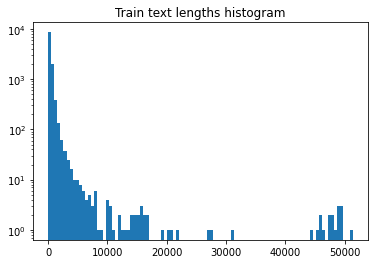

The shortest text: 35
The longest text: 134637


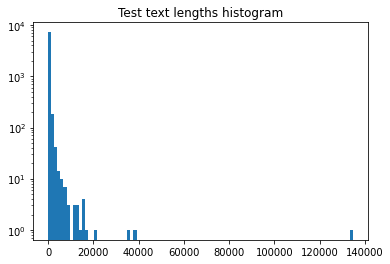

In [ ]:
"""Analyze the text lengths of training and testing data"""
def plot_text_lengths_hist(text_lengths, split):
  print(f'The shortest text: {min(text_lengths)}')
  print(f'The longest text: {max(text_lengths)}')
  plt.figure()
  plt.hist(text_lengths, bins=100)
  plt.yscale('log')
  plt.title(f'{split} text lengths histogram')
  plt.show()

train_lengths = []
for text in tqdm(newsgroups_train['data'], total=len(newsgroups_train['data'])):
  text = text.replace('\n', '')
  text_tokenized = tokenizer.tokenize(text)
  train_lengths.append(len(text_tokenized))

test_lengths = []
for text in tqdm(newsgroups_test['data'], total=len(newsgroups_test['data'])):
  text = text.replace('\n', '')
  text_tokenized = tokenizer.tokenize(text)
  test_lengths.append(len(text_tokenized))

plot_text_lengths_hist(train_lengths, split='Train')
plot_text_lengths_hist(test_lengths, split='Test')

# Process Data and Build Model

In [ ]:
"""Preprocess data and build training, dev and testing data"""
def split_tokens(tokens, chunk, overlap, **kwargs):
    """Split document tokens into segment chunks"""
    cls_value = kwargs.pop('cls', 2)
    sep_value = kwargs.pop('sep', 3)
    if kwargs: 
        raise TypeError(f"Unknown keyword arguments: {', '.join(kwargs.keys())}")

    token_segments = defaultdict(list)
    n = len(tokens) // chunk

    def add_special_tokens(token_segment):
        if len(token_segment) < chunk + overlap:
            pad_values = [0] * (chunk + overlap - len(token_segment))
            return [cls_value] + token_segment + [sep_value] + pad_values
        return [cls_value] + token_segment + [sep_value]

    for i in range(n+1):
        SEGMENT = slice(i * chunk, (i+1) * chunk + overlap)
        token_segment = tokens[SEGMENT]
        attention_mask = [1] * (2 + len(token_segment)) + [0] * (chunk + overlap - len(token_segment))
        token_segments['segment_ids'].append(add_special_tokens(token_segment))
        token_segments['segment_masks'].append(attention_mask)
        if i == n - 1 and len(token_segment) < chunk + overlap:
            break
    return token_segments

def building_features(newsgroups, threshold, message=None):
    if message:
        print(f'Building {message} features...')
    
    data = defaultdict(list)

    for idx, (text, target) in tqdm(enumerate(zip(newsgroups['data'], newsgroups['target']), 1), total=len(newsgroups['target'])):
        text = text.replace('\n', '')
        text_encode = tokenizer.encode(text, add_special_tokens=False, verbose=False)
        if len(text_encode) > threshold:
          text_encode = text_encode[:threshold]
        text_segments = split_tokens(text_encode, chunk=args.chunk, overlap=args.overlap)
        data['idxs'].append(idx)
        data['segment_ids'].append(text_segments['segment_ids'])
        data['attention_masks'].append(text_segments['segment_masks'])
        data['ys'].append(target)

    return data

def train_test_split(data, seed=0, train_split=0.9):
    train_total = test_total = 0
    train_data = defaultdict(list)
    test_data = defaultdict(list)
    
    def append_data(data, sub_data, idx):
        for key in data.keys():
            if key == 'idxs':
                sub_data[key].append(len(sub_data[key]) + 1)
            else:
                sub_data[key].append(data[key][idx])
    
    random.seed(seed)
    for i in range(len(data['idxs'])):
        rand_num = random.random()
        if rand_num < train_split:
            append_data(data, train_data, i)
        else:
            append_data(data, test_data, i)
        
    return train_data, test_data

train_data = building_features(newsgroups_train, args.threshold, message='train')
train_data, dev_data = train_test_split(train_data, seed=args.seed)
test_data = building_features(newsgroups_test, args.threshold, message='test')

Building train features...



Building test features...


In [ ]:
# Set up dataset and dataloader
class NewsGroupsDataSet(data.Dataset):
    def __init__(self, data):
        super().__init__()
        self.idxs = data['idxs']
        self.segment_ids = data['segment_ids']
        self.attention_masks = data['attention_masks']
        self.ys = data['ys']
    
    def __len__(self):
        return len(self.idxs)
    
    def __getitem__(self, idx):
        return tuple(getattr(self, key)[idx] for key in self.__dict__.keys())
            
def collate_fn(examples):
    def merge_0d(scalars, dtype=torch.int64):
        return torch.tensor(scalars, dtype=dtype)
    
    def merge_3d(arrays, max_len, dtype=torch.int64):
        padded = []
        for array in arrays:
            if len(array) < max_len:
                len_diff = max_len - len(array)
                array.extend([[0] * len(array[0]) for _ in range(len_diff)])
                padded.append(torch.tensor(array, dtype=dtype))
            else:
                padded.append(torch.tensor(array, dtype=dtype))
        
        return torch.stack(padded, dim=0)
    
    # Group by tensor type
    idxs, segment_ids, attention_masks, ys = zip(*examples)
    
    idxs = merge_0d(idxs)
    max_len_segment = max(len(segment_id) for segment_id in segment_ids)
    segment_ids = merge_3d(segment_ids, max_len_segment)
    attention_masks = merge_3d(attention_masks, max_len_segment)
    ys = merge_0d(ys)

    return (idxs, segment_ids, attention_masks, ys)
        
train_dataset = NewsGroupsDataSet(train_data)
dev_dataset = NewsGroupsDataSet(dev_data)
test_dataset = NewsGroupsDataSet(test_data)

train_loader = data.DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True, collate_fn=collate_fn)
dev_loader = data.DataLoader(dev_dataset, batch_size=args.batch_size, collate_fn=collate_fn)
test_loader = data.DataLoader(test_dataset, batch_size=args.batch_size, collate_fn=collate_fn)

print(f'Training data: {len(train_dataset)}')
print(f'Dev data: {len(dev_dataset)}')
print(f'Testing data: {len(test_dataset)}')

Training data: 10243
Dev data: 1071
Testing data: 7532


In [ ]:
"""Set up model"""
class NewsGroupsConfig():
    def __init__(self, args):
        self.pretrained_model = args.pretrained_model
        self.hidden_size = args.hidden_size
        self.nhead = args.nhead
        self.drop_prob = args.drop_prob
        self.num_labels = args.num_labels
        self.initializer_range = args.initializer_range
        self.max_segment_position = args.max_segment_position

class NewsGroupsSegmentEncoder(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.cls_segment_token = nn.Parameter(torch.Tensor(1, config.hidden_size))
        self.albert = AlbertModel.from_pretrained(config.pretrained_model)
        self.position_embeddings = nn.Embedding(config.max_segment_position, config.hidden_size)
        self.dropout = nn.Dropout(p=config.drop_prob)

        self.register_buffer("segment_position_ids", torch.arange(config.max_segment_position))
        self._init_weights()

    def _init_weights(self):
        torch.nn.init.normal_(self.cls_segment_token, mean=0.0, std=self.config.initializer_range)
        self.position_embeddings.weight.data.normal_(mean=0.0, std=self.config.initializer_range)

    def forward(self, content_ids, attention_masks):
        segment_vecs = []
        for content_id, attention_mask in zip(content_ids, attention_masks):
            # Get each segment encoding vector (number segment chunk * hidden size)
            segment_vec = self.albert(input_ids=content_id, attention_mask=attention_mask)[1]
            segment_vec = torch.cat((self.cls_segment_token, segment_vec), dim=0)
            segment_vecs.append(segment_vec)
        segment_vecs = torch.stack(segment_vecs, dim=1)
        
        # Add position embeddings
        segment_length = content_ids.size(1) + 1
        position_embeddings = self.position_embeddings(self.segment_position_ids[:segment_length])
        segment_vecs = segment_vecs + position_embeddings.unsqueeze(1)
        segment_vecs = self.dropout(segment_vecs)
        return segment_vecs

class NewsGroupsClassification(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.segment_encoder = NewsGroupsSegmentEncoder(config)
        encoder_layer = nn.TransformerEncoderLayer(d_model=config.hidden_size, nhead=config.nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.dropout = nn.Dropout(p=config.drop_prob)
        self.classifier = nn.Linear(in_features=config.hidden_size, out_features=config.num_labels)
      
        self._init_weights()

    def _init_weights(self):
        self.classifier.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
        self.classifier.bias.data.zero_()

    def _create_segment_masks(self, content_ids):
        device = content_ids.device
        batch_size = content_ids.size(0)
        cls_segment_mask = torch.zeros(batch_size, 1, dtype=torch.bool, device=device)
        segment_masks = content_ids.sum(axis=-1) == 0
        segment_masks = torch.cat((cls_segment_mask, segment_masks), dim=1)
        segment_length = content_ids.size(1) + 1
        # Shape: batch size * segment length * segment length
        segment_masks = segment_masks.repeat_interleave(segment_length, dim=0).view(batch_size, segment_length, -1)
        # Shape: batch size x nhead * segment length * segment length
        segment_masks = segment_masks.repeat_interleave(self.config.nhead, dim=0)
        return segment_masks
        
    def forward(self, content_ids, attention_masks):
        """Input shape: batch size * number segment chunk * segment length"""
        segment_vecs = self.segment_encoder(content_ids, attention_masks)
    
        # Get the first segment token, cls
        segment_masks = self._create_segment_masks(content_ids)
        document_vecs = self.transformer_encoder(segment_vecs, mask=segment_masks)[0]
        document_vecs = self.dropout(document_vecs)
        logits = self.classifier(document_vecs)
        log_p = F.log_softmax(logits, dim=-1)

        return log_p

# Train Model

In [ ]:
"""Build optimizer and scheduler to train model"""
def fit_model(model, optimizer, scheduler, train_loader, dev_loader, device, tbx, saver, args, step=0):
    """Train model on training set and evaluate on development set"""
    epoch = 0
    steps_till_eval = args.eval_steps
    nll_meter = AverageMeter()
    while epoch != args.num_epochs:
        epoch += 1
        model.train()
        count = args.batch_multiplier
        data_remaining = len(train_loader.dataset)
        optimizer.zero_grad()
        with torch.enable_grad(), tqdm(total=len(train_loader.dataset)) as pbar:
            for idxs, segment_ids, attention_masks, ys in train_loader:
                # Set up for forward
                idxs = idxs.to(device)
                segment_ids = segment_ids.to(device)
                attention_masks = attention_masks.to(device)
                batch_size = idxs.size(0)

                # Forward
                log_p = model(segment_ids, attention_masks)
                ys = ys.to(device)
                loss = F.nll_loss(log_p, ys) / args.batch_multiplier
                nll_meter.update(loss.item(), batch_size)

                # Backward
                loss.backward()
                count -= 1
                data_remaining -= 1

                # Accumulate gradient
                if count == 0:
                    nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
                    optimizer.step()
                    scheduler.step()
                    count = args.batch_multiplier if data_remaining >= args.batch_multiplier else data_remaining
                    optimizer.zero_grad()

                    # Log info
                    batch_size *= count
                    step += batch_size
                    pbar.update(batch_size)
                    pbar.set_postfix(epoch=epoch, NLL=nll_meter.sum)
                    tbx.add_scalar('train/NLL', nll_meter.sum, step)
                    tbx.add_scalar('train/LR_ft', optimizer.param_groups[0]['lr'], step)
                    tbx.add_scalar('train/LR', optimizer.param_groups[1]['lr'], step)
                    nll_meter.reset()

                    steps_till_eval -= batch_size
                    if steps_till_eval <= 0:
                        eval_acc, eval_loss = evaluate(model, dev_loader, device)
                        if saver.is_best(eval_acc):
                            saver.save(step, model, eval_acc, device)
                        tbx.add_scalar('dev/NLL', eval_loss, step)
                        tbx.add_scalar('dev/acc', eval_acc, step)
                        steps_till_eval = args.eval_steps

def evaluate(model, data_loader, device):
    model.eval()
    nll_meter = AverageMeter()
    correct = 0
    with torch.no_grad():
        for idxs, segment_ids, attention_masks, ys in data_loader:
            # Set up for Forward
            idxs = idxs.to(device)
            segment_ids = segment_ids.to(device)
            attention_masks = attention_masks.to(device)
            batch_size = idxs.size(0)
            
            # Forward
            log_p = model(segment_ids, attention_masks)
            ys = ys.to(device)
            loss = F.nll_loss(log_p, ys)
            
            nll_meter.update(loss.item(), batch_size)
            correct += sum(y.item()==torch.argmax(p).item() for y, p in zip(ys, log_p.exp()))
        acc = correct / len(data_loader.dataset)
    return acc, nll_meter.avg

# Set up arguments and devices
args = get_args()
save_dir, args.name = get_save_dir(args.base_dir, args.name)
saver = CheckpointSaver(save_dir, args.maximize_metric)
tbx = SummaryWriter(save_dir)
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

# Set random seed
torch.manual_seed(args.seed)
torch.cuda.manual_seed_all(args.seed)

# Set up model
config = NewsGroupsConfig(args)
model = NewsGroupsClassification(config)
model = model.to(device)
step = 0
if args.load_model:
    args.load_path = 'drive/MyDrive/colab/20newsgroups-03/best.pth.tar'
    model, step = load_model(model, args.load_path, device)

# Set up optimizer
optim_params = [{'params': [p for n, p in model.named_parameters() if 'albert' in n], 'lr': args.lr_ft},
                {'params': [p for n, p in model.named_parameters() if 'albert' not in n]}]
optimizer = optim.AdamW(optim_params, args.lr, weight_decay=args.l2_wd)

# Set up schedule
TOTAL_TRAINING_STEPS = len(train_dataset) * args.num_epochs // (args.batch_size * args.batch_multiplier)
args.warmup_steps = int(TOTAL_TRAINING_STEPS * 0.1)
args.num_cycles = 0.5
args.eval_steps = int(TOTAL_TRAINING_STEPS * 0.03)
def lr_lambda(step, warmup_steps=args.warmup_steps, num_cycles=args.num_cycles):
    if step < warmup_steps:
        return step / warmup_steps
    progress = float(step - warmup_steps) / float(TOTAL_TRAINING_STEPS - warmup_steps)
    return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress)))
scheduler = sched.LambdaLR(optimizer, lr_lambda)

# Log in arguments
with open(str(save_dir / 'log.txt'), 'w') as fp:
    json.dump(vars(args), fp, indent=4, sort_keys=True)

# Train model
fit_model(model, optimizer, scheduler,
          train_loader, dev_loader, device,
          tbx, saver, args, step=step)

Buffered data was truncated after reaching the output size limit.

# Model Evaluation

Model structures

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sn

from sklearn.metrics import confusion_matrix
from sklearn.manifold import TSNE

args.load_model = True
if args.load_model:
    device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
    config = NewsGroupsConfig(args)
    model = NewsGroupsClassification(config)
    model = model.to(device)

    args.load_path = 'drive/MyDrive/colab/20newsgroups-04/best.pth.tar'
    model = load_model(model, args.load_path, device, return_step=False)

for name, params in model.named_parameters():
    print(f'{name}: {params.shape}')

segment_encoder.cls_segment_token: torch.Size([1, 768])
segment_encoder.albert.embeddings.word_embeddings.weight: torch.Size([30000, 128])
segment_encoder.albert.embeddings.position_embeddings.weight: torch.Size([512, 128])
segment_encoder.albert.embeddings.token_type_embeddings.weight: torch.Size([2, 128])
segment_encoder.albert.embeddings.LayerNorm.weight: torch.Size([128])
segment_encoder.albert.embeddings.LayerNorm.bias: torch.Size([128])
segment_encoder.albert.encoder.embedding_hidden_mapping_in.weight: torch.Size([768, 128])
segment_encoder.albert.encoder.embedding_hidden_mapping_in.bias: torch.Size([768])
segment_encoder.albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.weight: torch.Size([768])
segment_encoder.albert.encoder.albert_layer_groups.0.albert_layers.0.full_layer_layer_norm.bias: torch.Size([768])
segment_encoder.albert.encoder.albert_layer_groups.0.albert_layers.0.attention.query.weight: torch.Size([768, 768])
segment_encoder.albert.encoder.a

Position embedding representation

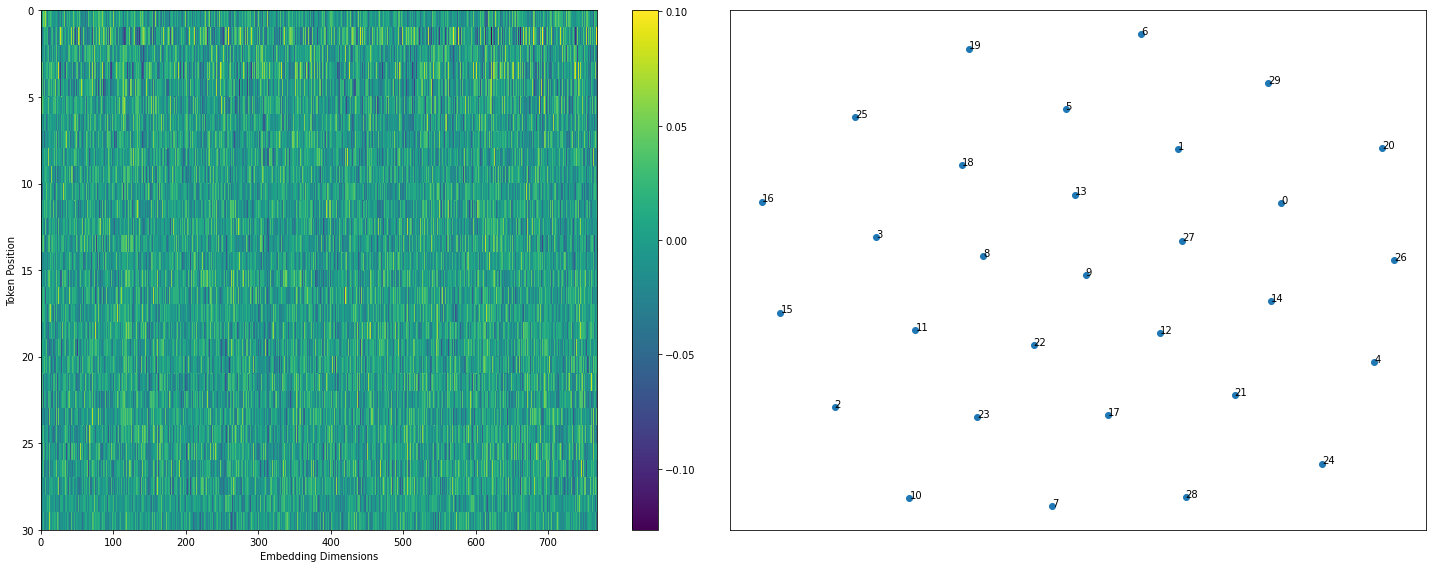

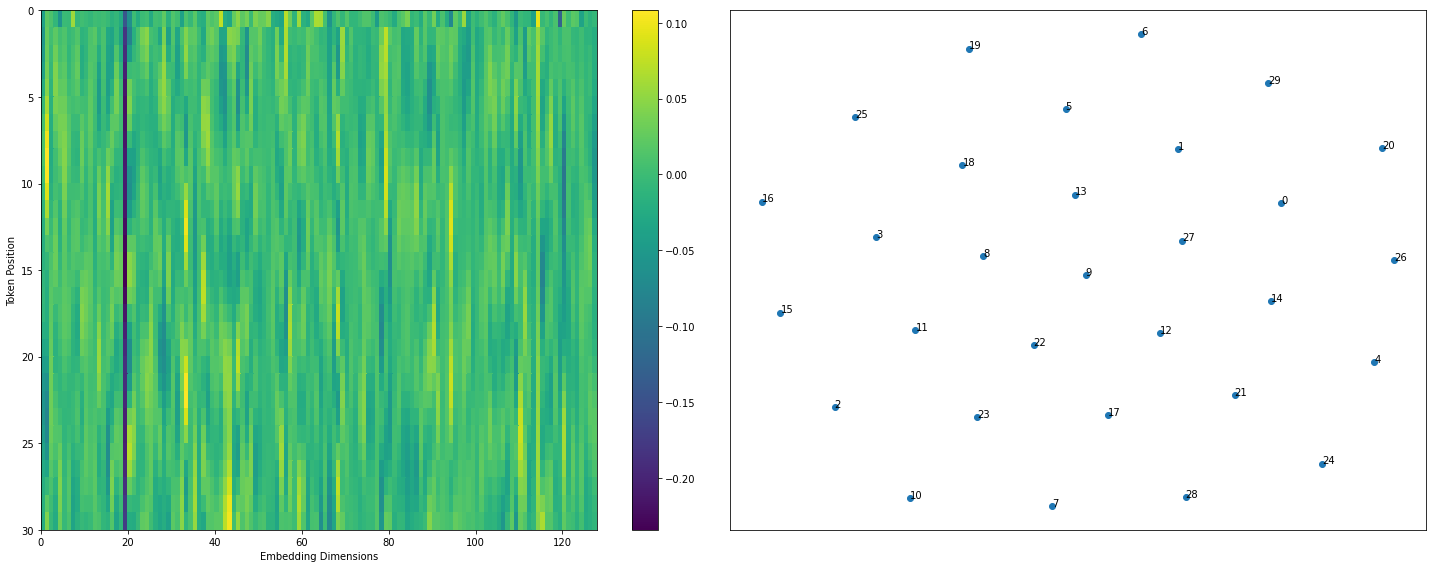

In [ ]:
"""Plot first n embeddings"""
def visualize_position_embeddings(position_embeddings, n=30):
    position_ids = torch.arange(n)
    embeddings = position_embeddings(position_ids).detach().numpy()
    embedding_size = embeddings.shape[1]

    # Pcolor plot of trained position embeddings
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    subplot = axes[0].pcolormesh(embeddings, cmap='viridis')
    axes[0].set_xlabel('Embedding Dimensions')
    axes[0].set_xlim((0, embedding_size))
    axes[0].set_ylim((n, 0))
    axes[0].set_ylabel('Token Position')
    fig.colorbar(subplot, ax=axes[0])

    # Scatter plot of trained dimension-reduced position embeddings
    embeddings_tsne = TSNE(n_components=2, random_state=args.seed).fit_transform(embeddings)
    axes[1].scatter(embeddings_tsne[:, 0], embeddings_tsne[:, 1])
    axes[1].tick_params(axis='both', which='both',    
                        bottom=False, left=False,
                        labelbottom=False, labelleft=False)
    for i, (emb_x, emb_y) in enumerate(embeddings_tsne):
        axes[1].annotate(i, (emb_x, emb_y))
    plt.tight_layout()
    plt.show()


position_embeddings = copy.deepcopy(model.segment_encoder.position_embeddings).cpu()
visualize_position_embeddings(position_embeddings)

position_embeddings_albert = AlbertModel.from_pretrained(config.pretrained_model).embeddings.position_embeddings
visualize_position_embeddings(position_embeddings_albert)

Test data prediction results


Accuracy: 0.82


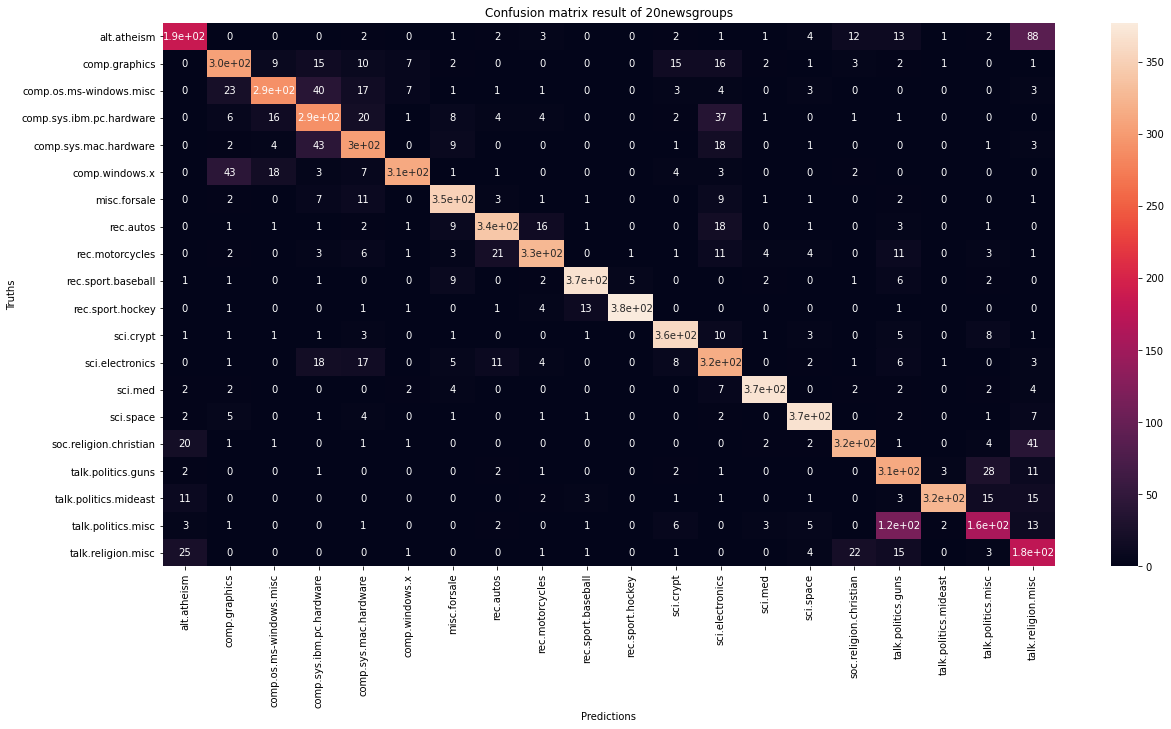

In [ ]:
"""Plot of confusion matrix"""
def plot_confusion_matrix(y_trues, y_preds, labels):
    cm = confusion_matrix(y_trues, y_preds)
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    plt.figure(figsize=(20, 10))
    sn.heatmap(df_cm, annot=True)
    plt.title(f'Confusion matrix result of 20newsgroups')
    plt.xlabel('Predictions')
    plt.ylabel('Truths')
    plt.show()

y_preds, y_trues = [], []
correct = 0
total = len(test_dataset)
with torch.no_grad(), tqdm(total=total) as pbar:
    for idxs, segment_ids, attention_masks, ys in test_loader:
        # Set up for Forward
        idxs = idxs.to(device)
        segment_ids = segment_ids.to(device)
        attention_masks = attention_masks.to(device)
        batch_size = idxs.size(0)
        
        # Forward
        log_p = model(segment_ids, attention_masks)
        y_pred = [torch.argmax(p).item() for p in log_p.exp()]
        y_preds.extend(y_pred)
        y_trues.extend(ys.tolist())
        correct += sum(y.item()==torch.argmax(p).item() for y, p in zip(ys, log_p.exp()))
        batch_size = idxs.size(0)
        pbar.update(batch_size)
    acc = correct / total
print(f'Accuracy: {acc:.2f}')
labels = newsgroups_test['target_names']
plot_confusion_matrix(y_trues, y_preds, labels)

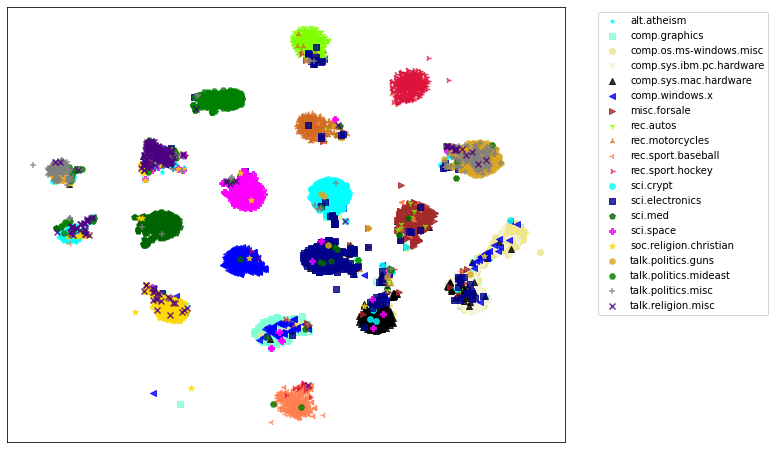

In [ ]:
"""Scatter plot of document contextual embeddings"""
def document_contextual_embeddings_hook(self, input, output):
    global document_contextual_embeddings
    document_contextual_embeddings = output

def plot_embeddings(embs_r, labels, label_names):
    markers = (".", ",", "o", "v", "^", "<", ">", "1", "2", "3",
               "4", "8", "s", "p", "P", "*", "h", "H", "+", "x")
    colors = ('aqua', 'aquamarine', 'khaki', 'beige', 'black',
              'blue', 'brown', 'chartreuse', 'chocolate', 'coral',
              'crimson', 'cyan', 'darkblue', 'darkgreen', 'fuchsia',
              'gold', 'goldenrod', 'green', 'grey', 'indigo')
    
    plt.figure(figsize=(10, 8))
    plt.tick_params(axis='both', which='both',    
                    bottom=False, left=False,
                    labelbottom=False, labelleft=False)
    for label in np.unique(labels):
        plt.scatter(embs_r[labels==label, 0], embs_r[labels==label, 1],
                    alpha=0.8, c=colors[label],
                    marker=markers[label], label=label_names[label])
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

model.transformer_encoder.register_forward_hook(document_contextual_embeddings_hook)

document_contextual_embeddings = None
doc_embeddings, labels = [], []
with torch.no_grad(), tqdm(total=len(test_dataset)) as pbar:
    for idxs, segment_ids, attention_masks, ys in test_loader:
        segment_ids = segment_ids.to(device)
        attention_masks = attention_masks.to(device)
        output = model(segment_ids, attention_masks)
        doc_embeddings += document_contextual_embeddings[0].tolist()
        labels += ys.tolist()

        batch_size = idxs.size(0)
        pbar.update(batch_size)
        
doc_embeddings_tsne = TSNE(n_components=2, random_state=args.seed).fit_transform(doc_embeddings)

label_names = newsgroups_test['target_names']
labels = np.array(labels)
plot_embeddings(doc_embeddings_tsne, labels, label_names)